In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from speedtest.utils.visualization import plot_comparison_histogram
from speedtest.utils.transform import OutlierRemover

In [3]:
# Reduce default figure size
plt.rcParams['figure.figsize'] = (4, 3)

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [5]:
cfg = OmegaConf.load('../../speedtest/conf/config.yaml')

## Load dataset

In [6]:
INPUTS = ['download_mbit', 'upload_mbit', 'time_utc']
TARGET = 'cat_technology'

In [7]:
df = pd.read_csv('../../data/processed/netztest-opendata-processed.csv')
df = df[INPUTS + [TARGET]]

In [8]:
df.sample(5)

,download_mbit,upload_mbit,time_utc,cat_technology
30142,18.197,0.282,2023-09-13 15:07:35,4G
27225,261.707,86.281,2023-09-11 10:26:04,5G
7931,327.135,7.799,2023-08-26 10:12:03,5G
4330,87.132,14.659,2023-08-23 13:03:08,5G
16865,76.168,17.949,2023-09-02 13:53:03,4G


In [9]:
df_features = pd.DataFrame()

## Preprocessing

<img src="image.png" alt="" width="800"/>

## Hour of day / day of week

In [10]:
df['time_cet'] = pd.to_datetime(df['time_utc'], utc=True).dt.tz_convert('Europe/Berlin')

In [11]:
df_features['hour_of_day_cet'] = df['time_cet'].dt.hour

In [12]:
df_features['day_of_week_cet'] = df['time_cet'].dt.weekday

In [13]:
df_features.sample(5)

,hour_of_day_cet,day_of_week_cet
15867,15,4
28806,16,1
13183,13,2
17056,19,5
24207,13,4


### download_mbits_clean

#### Clip outliers

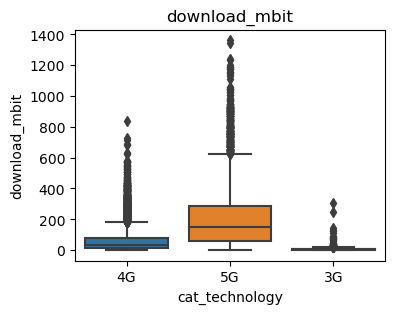

In [14]:
sns.boxplot(x='cat_technology', y='download_mbit', data=df)
plt.title('download_mbit')
plt.show()

In [15]:
limit = df['download_mbit'].quantile(.99)
limit

594.8073999999996

In [16]:
def clip_outliers(column: pd.Series, quantile: float = .99) -> pd.Series:
    column = column.copy()
    limit = column.quantile(quantile)
    column.loc[column > limit] = limit

    return column

df['download_mbit_wo_outliers'] = clip_outliers(df['download_mbit'])
df['upload_mbit_wo_outliers'] = clip_outliers(df['upload_mbit'])

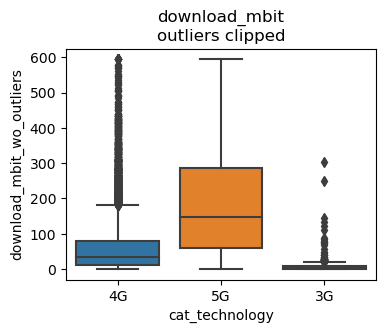

In [17]:
sns.boxplot(x='cat_technology', y='download_mbit_wo_outliers', data=df)
plt.title('download_mbit\noutliers clipped')
plt.show()

#### Min-Max scaling

<Axes: >

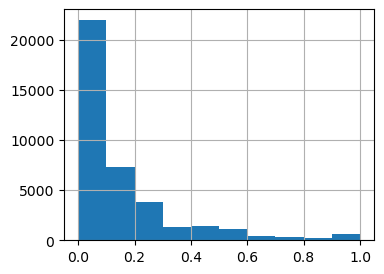

In [18]:
min_ = df['download_mbit_wo_outliers'].min()
max_ = df['download_mbit_wo_outliers'].max()

df_features['download_mbit_clean'] = (df['download_mbit_wo_outliers'] - min_) / max_

df_features['download_mbit_clean'].hist()

In [19]:
min_ = df['upload_mbit_wo_outliers'].min()
max_ = df['upload_mbit_wo_outliers'].max()

df_features['upload_mbit_clean'] = (df['upload_mbit_wo_outliers'] - min_) / max_

## ratio_up_down

In [20]:
df_features['ratio_up_down'] = (df_features['upload_mbit_clean'] / df_features['download_mbit_clean']).replace(np.inf, np.nan)
df_features['ratio_up_down'] = clip_outliers(df_features['ratio_up_down'])

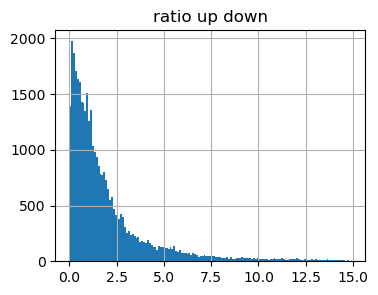

In [21]:
df_features['ratio_up_down'].hist(bins=np.arange(0, 15, 0.1))
plt.title('ratio up down')
plt.show()

In [22]:
# Select columns and fillna
df_features = df_features[[
    'hour_of_day_cet',
    'day_of_week_cet',
    'download_mbit_clean',
    'ratio_up_down'
]].fillna(0)

## Put it all into a function?

In [23]:
def get_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df_features = pd.DataFrame()

    # Convert utc to cet
    df['time_cet'] = pd.to_datetime(df['time_utc'], utc=True).dt.tz_convert('Europe/Berlin')

    # Extract hour
    df_features['hour_of_day_cet'] = df['time_cet'].dt.hour

    # Extract day of week
    df_features['day_of_week_cet'] = df['time_cet'].dt.weekday

    # Clip outliers
    df['download_mbit_wo_outliers'] = clip_outliers(df['download_mbit'])
    df['upload_mbit_wo_outliers'] = clip_outliers(df['upload_mbit'])

    # Min-Max scaling
    df_to_scale = df[['download_mbit_wo_outliers', 'upload_mbit_wo_outliers']]

    min_ = df_to_scale.min()
    max_ = df_to_scale.max()

    df_features[['download_mbit_clean', 'upload_mbit_clean']] = (df_to_scale - min_) / max_

    # Ratio up-down
    df_features['ratio_up_down'] = (df_features['upload_mbit_clean'] / df_features['download_mbit_clean']).replace(np.inf, np.nan)
    df_features['ratio_up_down'] = clip_outliers(df_features['ratio_up_down'])

    # Select features & fillna
    df_features = df_features[[
        'hour_of_day_cet',
        'day_of_week_cet',
        'download_mbit_clean',
        'ratio_up_down'
    ]].fillna(0)

    return df_features

In [25]:
X = df.copy()
y = X.pop(TARGET)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

X_train = get_features(X_train)
X_test = get_features(X_test)

In [26]:
X_train.sample(5)

,hour_of_day_cet,day_of_week_cet,download_mbit_clean,ratio_up_down
4188,12,2,0.015246,0.288582
11944,18,1,0.016415,0.348830
18692,13,0,0.009483,1.076830
34669,20,5,0.010861,1.742512
1843,17,0,0.264769,2.051085


# What is problematic about this?
* Artefacts of dataset-level transformations (mins, max, percentiles) are not stored but recalculated on each run, leading to inconsitent transformations
* Resulting dataset is no longer (easily) interpretable: Is 2 a Tuesday or Wednesday? - Depends on the library that was used!
* Function is a nightmare to read & debug because of lack of modularity and many implicit assumptions about structure of the input data
* Trained model is tightly coupled to feature-generating process, yet seperated'